## Pretrained GAN

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 14kB/s 
     |████████████████████████████████| 4.0MB 50.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [4]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

Uncomment the first time you run this notebook.

In [5]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [9]:
data_gen = get_data(bs,size)

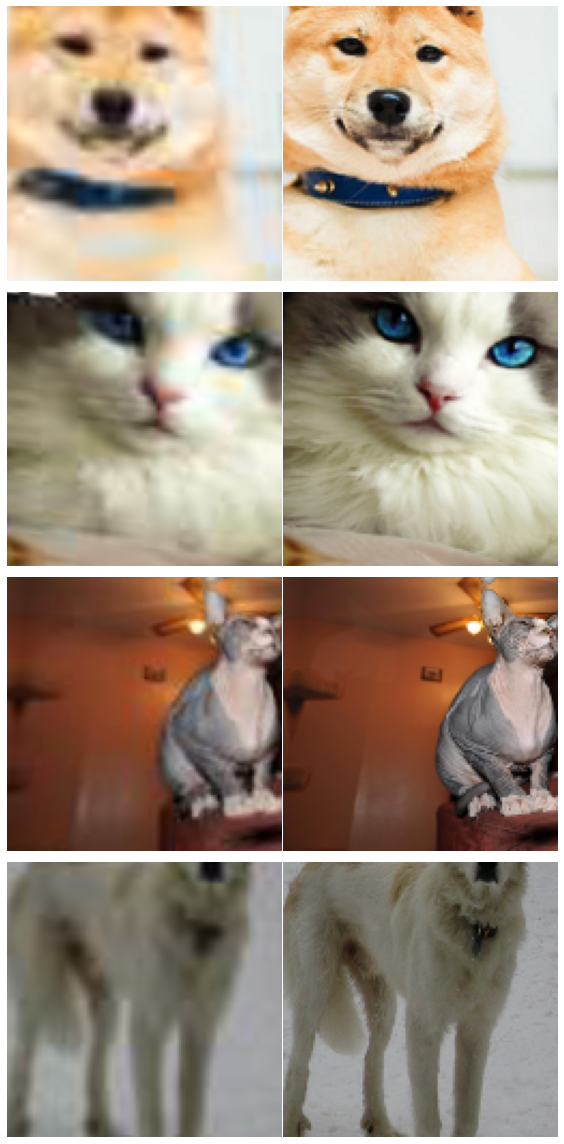

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3

In [12]:
y_range = (-3.,3.)

In [13]:
loss_gen = MSELossFlat()

In [14]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [16]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.065807,0.052297,02:07
1,0.051715,0.048571,02:01


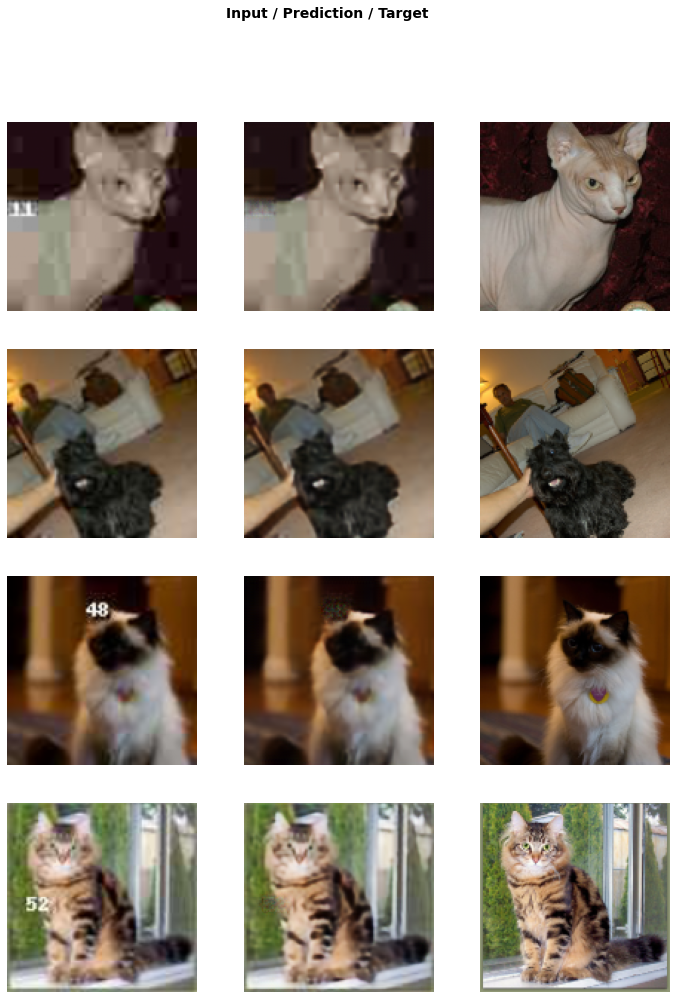

In [17]:
learn_gen.show_results(rows=4)

In [18]:
learn_gen.unfreeze()

In [19]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.051163,0.048790,02:04
1,0.049791,0.045942,02:01
2,0.047266,0.045472,02:02


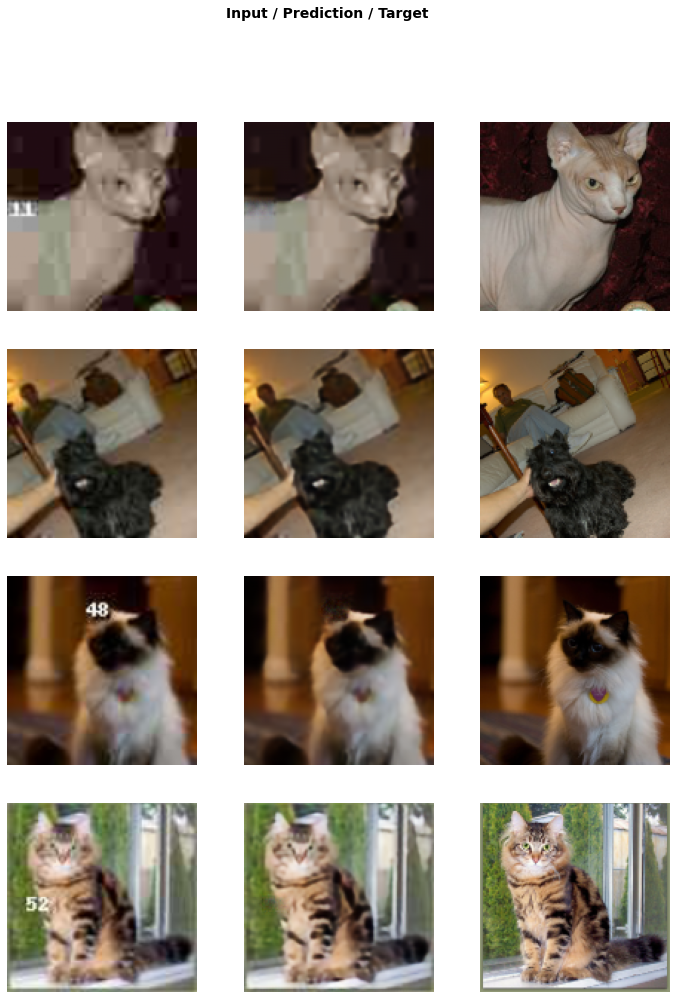

In [20]:
learn_gen.show_results(rows=4)

In [21]:
learn_gen.save('gen-pre2')

## Save generated images

In [22]:
learn_gen.load('gen-pre2');

In [23]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [24]:
path_gen.mkdir(exist_ok=True)

In [25]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [26]:
save_preds(data_gen.fix_dl)

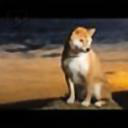

In [27]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [28]:
learn_gen=None
gc.collect()

22

Pretrain the critic on crappy vs not crappy.

In [29]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [30]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

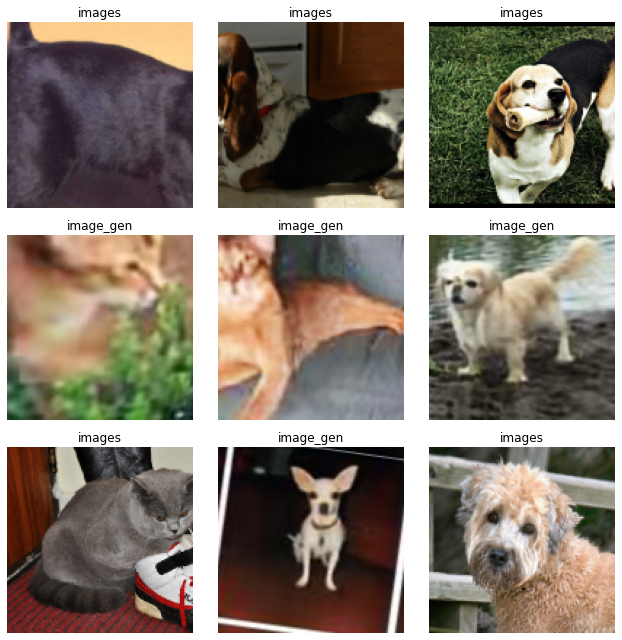

In [31]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [32]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [33]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [34]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [35]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.690546,0.690413,0.533732,04:07
1,0.480661,0.557600,0.657664,04:04
2,0.181180,0.202225,0.921909,04:04
3,0.107027,0.104724,0.962279,04:04
4,0.070667,0.103659,0.962336,04:04
5,0.047514,0.066553,0.979687,04:04


In [36]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [37]:
learn_crit=None
learn_gen=None
gc.collect()

19445

In [38]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [39]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [40]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [41]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [42]:
lr = 1e-4

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin